# CAPM Calculations with Exponential Weights #

### CAPM Model using Weighted Linear Regression Model ###

In [12]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Pretty Notation
from IPython.display import display, Math

In [13]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return w/np.sum(w)

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series, 
    risk_free_rate: pd.Series, 
    window: int = 252,
    WLS: bool = False,
    flip: bool = False,
):
    """*+ nñ-0..
    Computes the rolling beta of a stock using Weighted Least Squares (WLS) regression.
    
    Parameters:
    stock_prices (pd.Series): Time series of stock prices.
    benchmark_prices (pd.Series): Time series of benchmark prices.
    risk_free_rate (pd.Series): Time series of annualized risk-free rate.
    window (int): Rolling window size for regression.
    decay (float): Decay factor for exponential weighting (0 < decay < 1).
    
    Returns:
    pd.Series: Rolling beta of the stock.
    """

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []
    p_values_alpha, p_values_beta = [], []
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Create weights with exponential decay
            weights = window * wexp(window, window/2)
            weights = np.flip(weights) if flip else weights
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        pvalues = model.pvalues
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
        p_values_alpha.append(pvalues.iloc[0])
        p_values_beta.append(pvalues.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
        'p_value_alpha': p_values_alpha,
        'p_value_beta': p_values_beta
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [14]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

rfr

,risk_free_rate
Date,
2015-01-02,2.12
2015-01-05,2.04
2015-01-06,1.97
2015-01-07,1.96
2015-01-08,2.03
...,...
2025-02-13,4.52
2025-02-14,4.47
2025-02-18,4.55


In [15]:
# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

sp500

,sp_500
Date,
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
2015-01-09,2044.810059
...,...
2024-12-24,6040.040039
2024-12-26,6037.589844
2024-12-27,5970.839844


In [16]:
# Stock Data
ticker = 'MSFT'

df_stock = pd.read_csv(rf"..\stocks\{ticker}.csv")
df_stock = df_stock.set_index('Date')
df_stock.index = pd.to_datetime(df_stock.index)

df_stock

,Instrument,Open Price,High Price,Low Price,Close Price,Adjusted_close,Volume,Company Market Cap,Average Number of Shares Outstanding,Book Value per Share,...,Shares used to calculate Basic EPS - Total,T12M_Revenue,T12M_Net_Income,Announce_Date,Market_cap_calculado,Price_to_Sales,Price_to_Book,Price_to_Book_inverse,EPS_calculado,Price_to_Earnings
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,MSFT.OQ,16.203125,16.437500,16.187500,16.390625,16.390625,39747999.0,1.589979e+11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,MSFT.OQ,16.406250,16.703125,15.984375,16.296875,16.296875,80377599.0,1.580885e+11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-06,MSFT.OQ,16.218750,16.625000,16.156250,16.390625,16.390625,67834399.0,1.589979e+11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-07,MSFT.OQ,16.234375,16.398438,15.937500,16.195313,16.195313,61492799.0,1.571033e+11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-08,MSFT.OQ,16.078125,16.515625,15.937500,16.312500,16.312500,77657599.0,1.582401e+11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,MSFT.OQ,418.420000,430.570000,418.180000,427.510000,427.510000,NaN,NaN,7.475000e+09,36.114743,...,7.431000e+09,2.451220e+11,8.813600e+10,2024-07-30,3.178109e+12,12.965419,11.837548,0.084477,11.860584,36.044599
2024-10-23,MSFT.OQ,431.000000,431.000000,422.540000,424.600000,424.600000,NaN,NaN,7.475000e+09,36.114743,...,7.431000e+09,2.451220e+11,8.813600e+10,2024-07-30,3.156476e+12,12.877165,11.756971,0.085056,11.860584,35.799249
2024-10-24,MSFT.OQ,425.350000,425.950000,422.400000,424.730000,424.730000,NaN,NaN,7.475000e+09,36.114743,...,7.431000e+09,2.451220e+11,8.813600e+10,2024-07-30,3.157443e+12,12.881107,11.760571,0.085030,11.860584,35.810210


In [17]:
# Calculate the Betas using WLS

betas_wls_without_flip = CAPM(
    df_stock['Adjusted_close'],
    sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = True,
    flip = False
)

betas_wls_without_flip

,alpha,beta,p_value_alpha,p_value_beta
Date,,,,
2016-01-08,0.000190,1.314879,0.824342,2.405266e-34
2016-01-11,0.000245,1.308566,0.776127,6.079490e-34
2016-01-12,0.000261,1.311236,0.761938,8.952193e-34
2016-01-13,0.000216,1.302091,0.802908,7.652949e-33
2016-01-14,0.000218,1.298043,0.801676,7.557279e-33
...,...,...,...,...
2024-10-22,0.000108,1.050231,0.858209,2.198406e-31
2024-10-23,0.000036,1.064686,0.952102,8.118224e-32
2024-10-24,0.000050,1.062458,0.934823,3.213240e-31


In [18]:
# Calculate the Betas using WLS

betas_wls_with_flip = CAPM(
    df_stock['Adjusted_close'],
    sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = True,
    flip = True
)

betas_wls_with_flip

,alpha,beta,p_value_alpha,p_value_beta
Date,,,,
2016-01-08,0.001252,1.227385,0.108693,9.755424e-42
2016-01-11,0.001366,1.216033,0.080937,4.341158e-41
2016-01-12,0.001350,1.216352,0.083855,4.987097e-41
2016-01-13,0.001325,1.213460,0.088716,7.116219e-41
2016-01-14,0.001371,1.201614,0.078005,2.339421e-41
...,...,...,...,...
2024-10-22,-0.000680,1.086655,0.198606,5.335590e-42
2024-10-23,-0.000543,1.086255,0.314189,1.290291e-40
2024-10-24,-0.000511,1.081856,0.341523,1.520590e-40


In [19]:
# Calculate the Betas using OLS

betas_ols = CAPM(
    df_stock['Adjusted_close'],
    sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = False,
)

betas_ols

,alpha,beta,p_value_alpha,p_value_beta
Date,,,,
2016-01-08,0.000780,1.259569,0.340796,1.750192e-37
2016-01-11,0.000859,1.251158,0.296019,4.981878e-37
2016-01-12,0.000860,1.252349,0.295452,6.202565e-37
2016-01-13,0.000828,1.247273,0.313295,1.811865e-36
2016-01-14,0.000855,1.238996,0.298342,1.182856e-36
...,...,...,...,...
2024-10-22,-0.000317,1.083515,0.573311,3.247167e-37
2024-10-23,-0.000290,1.089524,0.609050,5.936762e-37
2024-10-24,-0.000273,1.087064,0.630246,1.119180e-36


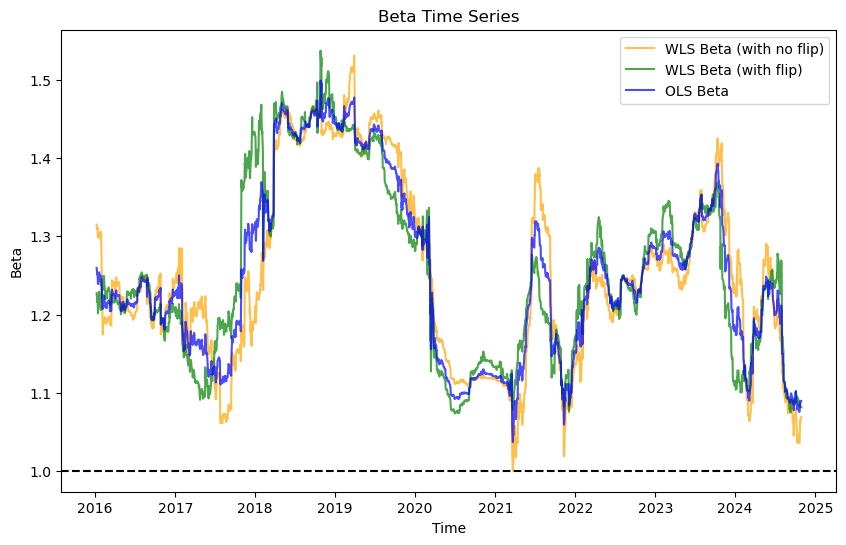

In [20]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_wls_without_flip['beta'], label='WLS Beta (with no flip)', color='orange', alpha=0.7)
plt.plot(betas_wls_with_flip['beta'], label='WLS Beta (with flip)', color='green', alpha=0.7)
plt.plot(betas_ols['beta'], label='OLS Beta', color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.show()

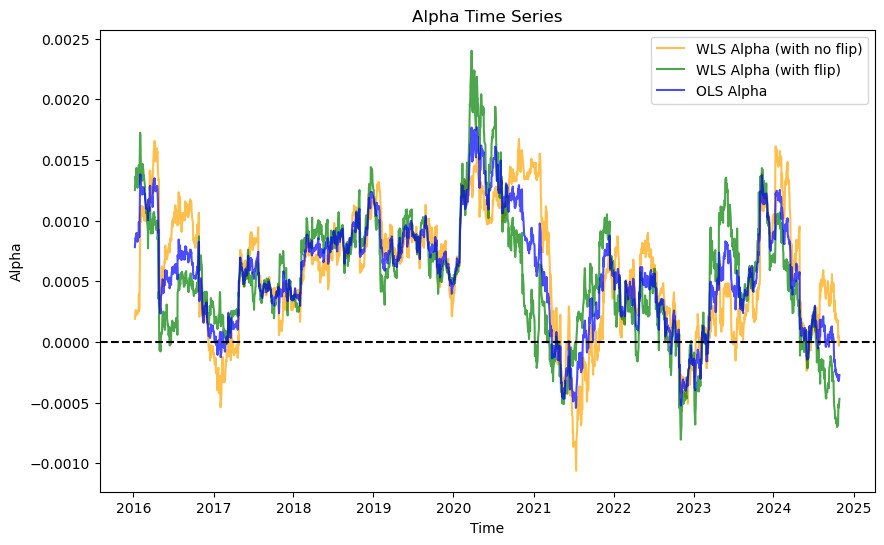

In [21]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_wls_without_flip['alpha'], label='WLS Alpha (with no flip)', color='orange', alpha=0.7)
plt.plot(betas_wls_with_flip['alpha'], label='WLS Alpha (with flip)', color='green', alpha=0.7)
plt.plot(betas_ols['alpha'], label='OLS Alpha', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.show()

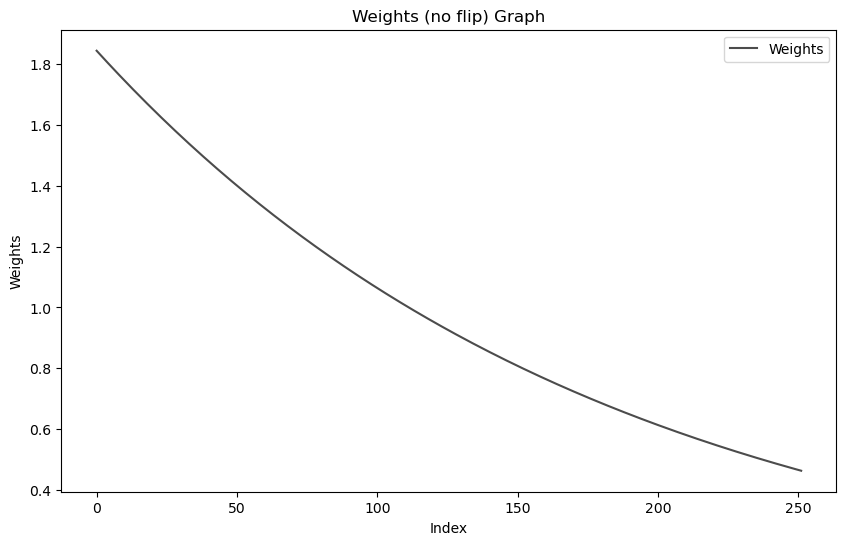

In [22]:
# Create Plot

weights = 252 * wexp(252, 126)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights (no flip) Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

In [23]:
# Let us make an example
weights = 252 * wexp(252, 126)
x = np.arange(1, 253) # A Trend Series

a_case = x.T @ weights
b_case = x.T @ np.flip(weights)

if a_case < b_case:
    print("Weights with no flip are biased to the future")
elif a_case > b_case:
    print("Weights with flip are biased to the past")
else:
    print("Both Weights are equal")

Weights with no flip are biased to the future


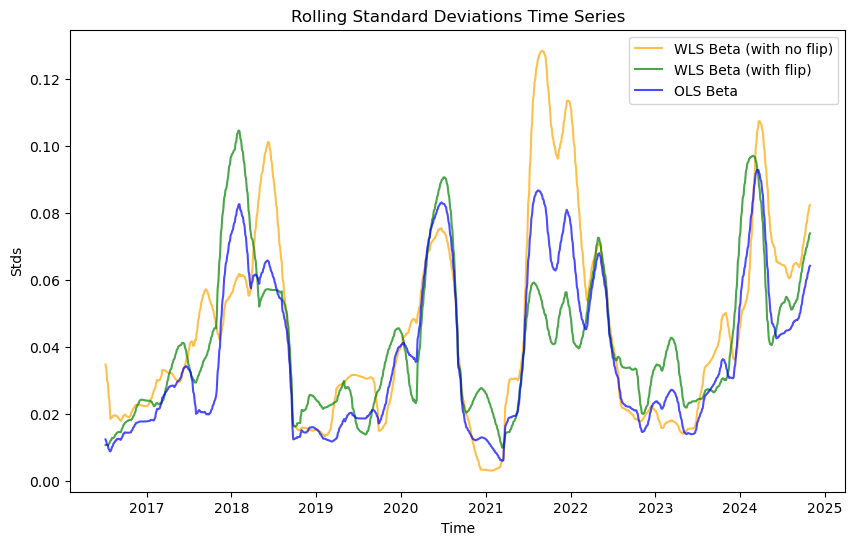

In [24]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_wls_without_flip['beta'].rolling(window=126).std(), label='WLS Beta (with no flip)', color='orange', alpha=0.7)
plt.plot(betas_wls_with_flip['beta'].rolling(window=126).std(), label='WLS Beta (with flip)', color='green', alpha=0.7)
plt.plot(betas_ols['beta'].rolling(window=126).std(), label='OLS Beta', color='blue', alpha=0.7)

# Config
plt.title('Rolling Standard Deviations Time Series')
plt.xlabel('Time')
plt.ylabel('Stds')
plt.legend()

# Show
plt.show()

In [25]:
# Calculate another kind of weights
lambda_decay = 0.97  
window = 252 

# Weights 
weights_alt = np.array([lambda_decay ** (window - t) for t in range(1, window + 1)])

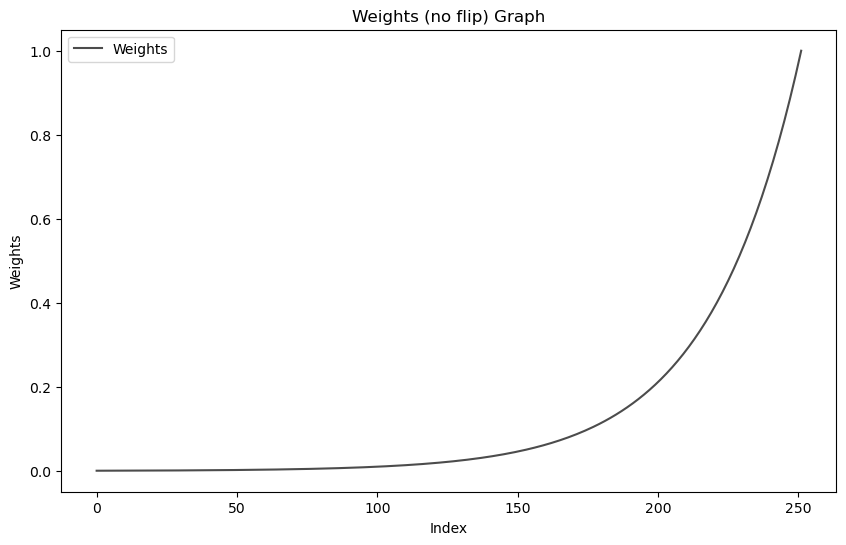

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(weights_alt, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights (no flip) Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

Concluding that indeed we have to use the weights with flip